# <h1> **PREDICCIÓN DE DESERCIÓN DE CLIENTES EN BETA BANK** </h1>

## **DESCRIPCIÓN DEL PROYECTO**

<p> Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.</p>

<p>Necesitamos predecir si un cliente dejará el banco pronto. Se tienen los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.</p>

**Características** 

* RowNumber: índice de cadena de datos
* CustomerId: identificador de cliente único
* Surname: apellido
* CreditScore: valor de crédito
* Geography: país de residencia
* Gender: sexo
* Age: edad
* Tenure: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)
* Balance: saldo de la cuenta
* NumOfProducts: número de productos bancarios utilizados por el cliente
* HasCrCard: el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)
* IsActiveMember: actividad del cliente (1 - sí; 0 - no)
* EstimatedSalary: salario estimado

**Objetivo**

* Exited: El cliente se ha ido (1 - sí; 0 - no)

Para solentar la probelmatica se realizará un algoritmo de Machine Learning que nos permita predecir cuando un cliente dejará la empresa en base a las caracteríasticas y valores históricos de los clientes.

## **LIBRERÍAS**

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score 

## **PREPROCESAMIENTO DE DATOS**

Primeramente importamos el Data Frame y se procede a estudiar sus caracteríasticas

In [16]:
try:
  churn = pd.read_csv('/content/drive/MyDrive/practicum/Sprint8/Churn.csv')
except:
  churn = pd.read_csv('/datasets/Churn.csv')

Se procede a observar las primeras 5 filas

In [17]:
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Se procede a verificar que las columnas no tengan valores ausentes y que tengamos los tipos de dato correctos en cada una

In [18]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Como se puede observar se tiene algunos valores ausnetes en la columna de `Tenure` el cual contiene información sobre el período durante el cual ha madurado el depósito a plazo fijo de un cliente (años) cuya ausencia lopuede significar que no posee ningún depósito de este típo, por lo cual el espacio se dejó en blanco y para no perder las caracteríasticas simplemenete sustituiremos el valor por 0. Y para ver como afecta la preducciín de los valores, vamos a realizar un desglose de los curtiles, así como de su media, mediana y desviación estandar antes y depués del cambio.

Se deciden eliminar las columnas de `CustomerId`, `RowNumber` y `Surname` ya que las mismas no son relevantes para el algoritmo de Machine Learning

In [19]:
churn = churn.drop(['CustomerId', 'RowNumber', 'Surname'], axis = 1)

In [20]:
churn.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [21]:
churn['Tenure'] = churn['Tenure'].fillna(0)

In [22]:
churn.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.543400,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,3.111573,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,4.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Como era de esperarse, la diferencia no fué demasaida, por lo que se puede decir que no afectará demasiado las conclusiones de nuestro modelo.

Para estudiar algunas características, se procede a encontrar la distribución de los datos para personas que salieron de la empresa y las que no, y poder ver si hay algún factor que determine a simple vista la salidad de los mismos.

In [23]:
churn[churn['Exited']==0].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.0
mean,651.853196,37.408389,4.564360,72745.296779,1.544267,0.707146,0.554565,99738.391772,0.0
std,95.653837,10.125363,3.104189,62848.040701,0.509536,0.455101,0.497045,57405.586966,0.0
min,405.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,90.070000,0.0
25%,585.000000,31.000000,2.000000,0.000000,1.000000,0.000000,0.000000,50783.490000,0.0
50%,653.000000,36.000000,5.000000,92072.680000,2.000000,1.000000,1.000000,99645.040000,0.0
75%,718.000000,41.000000,7.000000,126410.280000,2.000000,1.000000,1.000000,148609.955000,0.0
max,850.000000,92.000000,10.000000,221532.800000,3.000000,1.000000,1.000000,199992.480000,0.0


In [24]:
churn[churn['Exited']==1].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.000000,2037.0
mean,645.351497,44.837997,4.461463,91108.539337,1.475209,0.699067,0.360825,101465.677531,1.0
std,100.321503,9.761562,3.139693,58360.794816,0.801521,0.458776,0.480358,57912.418071,0.0
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,1.0
25%,578.000000,38.000000,2.000000,38340.020000,1.000000,0.000000,0.000000,51907.720000,1.0
50%,646.000000,45.000000,4.000000,109349.290000,1.000000,1.000000,0.000000,102460.840000,1.0
75%,716.000000,51.000000,7.000000,131433.330000,2.000000,1.000000,1.000000,152422.910000,1.0
max,850.000000,84.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199808.100000,1.0


### CONCLUSIÓN INTERMEDIA

Primeramente se observó la presencia de algunos valores ausnetes en la columna de `Tenure` el cual contiene información sobre el período durante el cual ha madurado el depósito a plazo fijo de un cliente (años) cuya ausencia lo que puede significar que no posee ningún depósito de este típo, por lo cual el espacio se dejó en blanco y para no perder las caracteríasticas simplemenete sustituiremos el valor por 0.

Además no existe un valor demasiado claro que nos permita determinar si un cliente se irá o no, vemos que las variaciones son bastente sutiles, es por eso que se recurre al Machine Learning

## **ALGORITMO DE MACHINE LEARNING**

### Regresión logística

Primeramente, como se tienene características que no son numéricas, se decide optar por una separación de los datos por medio de variable dummies, que nos permite asignarar valores numéricos de 1 y 0 dependiendo de si el caso cumple o no y eliminamos la última columna que se sobreentiende.

In [25]:
data_ohe = pd.get_dummies(churn, drop_first=True)
target = data_ohe['Exited'] 
features = data_ohe.drop('Exited', axis=1) 
features_train, features_valid, target_train, target_valid = train_test_split( features, target, test_size=0.4, random_state=12345)
features_valid, features_probe,  target_valid, target_probe = train_test_split( features_valid, target_valid, test_size=0.5, random_state=12345)

Luego entrenamos un modelo de `LogisticRegression` sin tomar en cuenta el desequilibrio de los valores

In [26]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.08385744234800838


Como podemos ver la relación de el recall y la presición es nula, por lo que se procede a escalar los valores para poder entrenar el modelo

In [27]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train2 = scaler.transform(features_train)
features_valid2 = scaler.transform(features_valid)

Volvemos a entrenar y observamos el valor de F1

In [28]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_train2,target_train)
predicted_valid = model.predict(features_valid2)
print('F1:', f1_score(target_valid, predicted_valid))

F1: 0.3333333333333333


Como se puede observar, el valor de `F1` aumentó, sin embargo, sigue siendo demasiado bajo, por lo que se decide cambiar de enfoque, y utilizar el sobremuestro, para ello se crea la función `upsample` que nos permite aplicar este método y devolver 2 conjuntos sobremuestreados

In [29]:
def upsample(features,target,repeat):
    features_zeros = features[target== 0]
    features_ones = features[target == 1]
    target_zeros = target[target== 0]
    target_ones = target[target == 1]
    agg1 = pd.concat([features_zeros] + [features_ones] * repeat)
    agg2 = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(agg1, agg2, random_state=12345)
    return features_upsampled, target_upsampled 
  

Se procede a enconrar el mejor modelo, probando diferentes combinaciones de sobremuestreo hasta llegar al valor más alto de F1 posible

In [30]:
best_repeat = 0
best_f1 = 0
best_model = None
for i in range(1,20):
  features_upsampled, target_upsampled = upsample(features_train, target_train, i)
  model = LogisticRegression(random_state = 12345, solver = 'liblinear')
  model.fit(features_upsampled, target_upsampled)
  predicted_valid = model.predict(features_valid)
  f1 = f1_score(target_valid, predicted_valid)
  if f1 > best_f1:
    best_f1 = f1
    best_repeat = i
    best_model = model
print('El mejor valor de F1 encontrado es: ',best_f1, 'con:',best_repeat,'repeticiones')

El mejor valor de F1 encontrado es:  0.45286059629331177 con: 4 repeticiones


Como se observa, intentando hasta 20 repetiiciones de los valores, la mejor combinación nos arrojó un valor mucho mejor de 0.45, con 4 repeticiones, sin embargo sigue siendo bajo, se procede a modificar el umbral para aumentar un poco el valor de `F1` y determinar si ahora si tiene un valor mejor

In [31]:
model = best_model
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, f1 = {:.3f}'.format(
            	threshold, precision, recall,f1))

Threshold = 0.00 | Precision = 0.209, Recall = 1.000, f1 = 0.346
Threshold = 0.02 | Precision = 0.209, Recall = 1.000, f1 = 0.346
Threshold = 0.04 | Precision = 0.209, Recall = 1.000, f1 = 0.346
Threshold = 0.06 | Precision = 0.209, Recall = 1.000, f1 = 0.346
Threshold = 0.08 | Precision = 0.209, Recall = 1.000, f1 = 0.346
Threshold = 0.10 | Precision = 0.209, Recall = 1.000, f1 = 0.346
Threshold = 0.12 | Precision = 0.210, Recall = 1.000, f1 = 0.347
Threshold = 0.14 | Precision = 0.211, Recall = 1.000, f1 = 0.348
Threshold = 0.16 | Precision = 0.213, Recall = 1.000, f1 = 0.351
Threshold = 0.18 | Precision = 0.215, Recall = 0.998, f1 = 0.354
Threshold = 0.20 | Precision = 0.217, Recall = 0.995, f1 = 0.356
Threshold = 0.22 | Precision = 0.219, Recall = 0.988, f1 = 0.359
Threshold = 0.24 | Precision = 0.222, Recall = 0.981, f1 = 0.363
Threshold = 0.26 | Precision = 0.225, Recall = 0.971, f1 = 0.365
Threshold = 0.28 | Precision = 0.231, Recall = 0.964, f1 = 0.373
Threshold = 0.30 | Precis

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Se logró aumentar hasta un F1 = 0.492 con un valor de umbral de 0.52, sinembargo sigue sin ser suficiente.

Intentemos submuestrearlo para ver si el modelo mejora.

In [32]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    agg1 = pd.concat([features_zeros.sample(frac = fraction, random_state = 12345)] + [features_ones])
    agg2 = pd.concat([target_zeros.sample(frac = fraction, random_state = 12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(agg1, agg2, random_state=12345)
    
    return features_downsampled, target_downsampled

In [33]:
best_repeat = 0
best_f1 = 0
best_model = None
for i in np.arange(0.1,0.9,0.1):
  features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)
  model = LogisticRegression(random_state = 12345, solver = 'liblinear')
  model.fit(features_upsampled, target_upsampled)
  predicted_valid = model.predict(features_valid)
  f1 = f1_score(target_valid, predicted_valid)
  if f1 > best_f1:
    best_f1 = f1
    best_repeat = i
    best_model = model
print('El mejor valor de F1 encontrado es: ',best_f1, 'con:',best_repeat,'repeticiones')

El mejor valor de F1 encontrado es:  0.3542905692438403 con: 0.1 repeticiones


#### CONCLUCIÓN INTERMEDIA

Como podemos observar, no obtuvimos mejora alguna, por lo que se decide cambiar a un modelo de bosque aleatorio de decisión, para ello, buscamos valores posibles de sobremuestreo con diferente cantidad de estimadores, para encontrar el mejor modelo posible, ya que el modelo de regresión logistica no da los resultados esperados en este caso.

### Arbol aleatorio de decisión

In [40]:
best_repeat = 0
best_f1 = 0
best_trees = 0
best_model = None
for i in range(17,25):
  for j in range(1,100,10):
    features_upsampled, target_upsampled = upsample(features_train, target_train, i)
    model = RandomForestClassifier(random_state=54321, n_estimators=j)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
      best_f1 = f1
      best_repeat = i
      best_model = model
      best_trees = j
print('El mejor valor de F1 encontrado es: ',best_f1, 'con:',best_repeat,'repeticiones y',best_trees,'arboles')

El mejor valor de F1 encontrado es:  0.46836847946725857 con: 23 repeticiones y 1 arboles
El mejor valor de F1 encontrado es:  0.5798969072164948 con: 23 repeticiones y 11 arboles
El mejor valor de F1 encontrado es:  0.5798969072164948 con: 23 repeticiones y 11 arboles
El mejor valor de F1 encontrado es:  0.5984455958549223 con: 23 repeticiones y 31 arboles
El mejor valor de F1 encontrado es:  0.5984455958549223 con: 23 repeticiones y 31 arboles
El mejor valor de F1 encontrado es:  0.5984455958549223 con: 23 repeticiones y 31 arboles
El mejor valor de F1 encontrado es:  0.5984455958549223 con: 23 repeticiones y 31 arboles
El mejor valor de F1 encontrado es:  0.5984455958549223 con: 23 repeticiones y 31 arboles
El mejor valor de F1 encontrado es:  0.5984455958549223 con: 23 repeticiones y 31 arboles
El mejor valor de F1 encontrado es:  0.5984455958549223 con: 23 repeticiones y 31 arboles
El mejor valor de F1 encontrado es:  0.5984455958549223 con: 23 repeticiones y 31 arboles


El mejor modelo se logró con un sobre muestreo de 19, y 31 arboles o estimadores, arrojando un valor de F1 = 0.59 un valor bastante aceptable y bueno. Pero se puede mejorar aún más modificando el umbral.

In [41]:
model = best_model
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, f1 = {:.3f}'.format(
            	threshold, precision, recall,f1))

Threshold = 0.00 | Precision = 0.235, Recall = 0.974, f1 = 0.379
Threshold = 0.02 | Precision = 0.235, Recall = 0.974, f1 = 0.379
Threshold = 0.04 | Precision = 0.264, Recall = 0.950, f1 = 0.414
Threshold = 0.06 | Precision = 0.264, Recall = 0.950, f1 = 0.414
Threshold = 0.08 | Precision = 0.291, Recall = 0.916, f1 = 0.442
Threshold = 0.10 | Precision = 0.315, Recall = 0.878, f1 = 0.464
Threshold = 0.12 | Precision = 0.315, Recall = 0.878, f1 = 0.464
Threshold = 0.14 | Precision = 0.346, Recall = 0.849, f1 = 0.492
Threshold = 0.16 | Precision = 0.346, Recall = 0.849, f1 = 0.492
Threshold = 0.18 | Precision = 0.381, Recall = 0.818, f1 = 0.520
Threshold = 0.20 | Precision = 0.416, Recall = 0.794, f1 = 0.546
Threshold = 0.22 | Precision = 0.416, Recall = 0.794, f1 = 0.546
Threshold = 0.24 | Precision = 0.445, Recall = 0.751, f1 = 0.559
Threshold = 0.26 | Precision = 0.474, Recall = 0.734, f1 = 0.577
Threshold = 0.28 | Precision = 0.474, Recall = 0.734, f1 = 0.577
Threshold = 0.30 | Precis

Como se observa el mejor modelo, tiene un valor de umbral del 0.5, obteniendo un valor de F1 del 0.598.

Para observar la cordura del modelo, se muestra a continuación la mtriz de confusuión

In [42]:
predicted_valid = probabilities_one_valid > 0.5
confusion_matrix(target_valid, predicted_valid)

array([[1459,  123],
       [ 187,  231]])

En base a esto, la presición, la sensibilidad y el valor de F1 podemos decir que este modelo es bastanet bueno pra predecir a los empleados que van a desertar del banco. Sin embargo qué tanto? a continuación se grafica la curva de sensibilidadvs presición

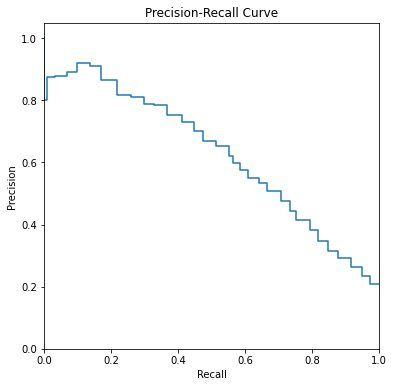

In [43]:
probabilities_valid = best_model.predict_proba(features_valid) 
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1] ) 
plt.figure(figsize=(6, 6)) 
plt.step(recall, precision, where='post') 
plt.xlabel('Recall') 
plt.ylabel('Precision') 
plt.ylim([0.0, 1.05]) 
plt.xlim([0.0, 1.0]) 
plt.title('Precision-Recall Curve') 
plt.show() 

Se logra una curva bastante elevada, lo cual indica una alta calidad

Por último estudiamos el AUC-ROC del modelo el cual es una herramienta estadística que se utiliza para medir el acierto en la predicción de eventos binarios, es decir, eventos que bien ocurren o no ocurren como en este caso. Para ello se trazan 2 gráficas, nuestro modelo de alta calidad, y un modelo aleatorio la cual es una linea recta, que quiere decir que nuestro modelo no predice, sino que tiene un 50% de probabilidad de acierto, solo adivina en pocas palabras.



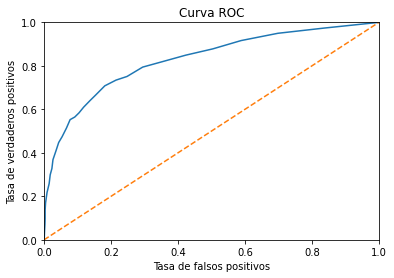

In [44]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
plt.figure()

# < traza la gráfica >
plt.plot(fpr, tpr, linestyle='-')
# Curva ROC para modelo aleatorio (parece una línea recta)
plt.plot([0, 1], [0, 1], linestyle='--')

# < utiliza las funciones plt.xlim() y plt.ylim() para
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
# < utiliza las funciones plt.xlabel() y plt.ylabel() para
#   nombrar los ejes "Tasa de falsos positivos" y "Tasa de verdaderos positivos">
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
# < agrega el encabezado "Curva ROC" con la función plt.title() >
plt.title('Curva ROC')
plt.show()

En este caso la linea azul, es el modelo creado con el algoritmo, y la linea de color verde, es el modelo aleatorio. si calculamos el area bajo la curva podremos ver que tanto difiere nuestro modelo del aleatorio, y determinar así nuestro modelo solo adivina o si de verdad predice

In [45]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

0.8278804916555266


Realizando el cáculo, podemos determinar que efectivamente al 0.83>0.5 el modelo si predice con una probabilidad del 83% de acierto.

In [46]:
best_model.score(features_valid, target_valid)

0.845

In [47]:
best_model.score(features_probe, target_probe)

0.8365

In [49]:
probabilities_probe = best_model.predict_proba(features_probe)
probabilities_one_probe = probabilities_probe[:, 1]
predicted_probe = probabilities_one_probe > 0.5
precision = precision_score(target_probe, predicted_probe)
recall = recall_score(target_probe, predicted_probe)
f1 = f1_score(target_probe, predicted_probe)
auc_roc = roc_auc_score(target_probe, probabilities_one_probe)

print('Valores de la prueba del modelo')
print('F1 =',f1)
print('recall =',recall)
print('precision =',precision)
print('Auc-Roc =', auc_roc )

Valores de la prueba del modelo
F1 = 0.5645805592543276
recall = 0.5011820330969267
precision = 0.6463414634146342
Auc-Roc = 0.8354807809063802


Como se piede observar se obtuvo un muy buen modelo en este caso, que arrojó buenos resultados para el conjunto de prueba, sin embargo vanmos a reentrenar el modelo con más data para mejorar dichos valores uniendo el conjunto de entrenamiento y validadción

In [50]:
feaures_train_2 = pd.concat([features_train,features_valid], axis = 0)
target_train_2 = pd.concat([target_train,target_valid], axis = 0)

In [51]:
features_upsampled, target_upsampled = upsample(feaures_train_2, target_train_2, 23)
model = RandomForestClassifier(random_state=54321, n_estimators=31)
model.fit(features_upsampled, target_upsampled)
predicted_probe = model.predict(features_probe)
precision = precision_score(target_probe, predicted_probe)
recall = recall_score(target_probe, predicted_probe)
f1 = f1_score(target_probe, predicted_probe)
auc_roc = roc_auc_score(target_probe, probabilities_one_probe)


print('Valores de la prueba del modelo')
print('F1 =',round(f1*100,2), '%')
print('recall =',round(recall*100,2), '%')
print('precision =',round(precision*100,2), '%')
print('Auc-Roc =', round(auc_roc*100,2), '%')


Valores de la prueba del modelo
F1 = 57.56 %
recall = 51.3 %
precision = 65.56 %
Auc-Roc = 83.55 %


Como podemos observar, se elevaron los valores dde sensibilidad, presición exactitud, F1 y area bajo la curva. Ahora bien, podemos ver si para ete nuevo conjunto tenemos mejores valores volviendo a correr el codigo que nos pemrite determinarlo, pero ajora con estos nuevos conjuntos de entrenamiento

In [54]:
best_repeat = 0
best_f1 = 0
best_trees = 0
best_model = None
for i in range(17,25):
  for j in range(1,100,10):
    features_upsampled, target_upsampled = upsample(feaures_train_2, target_train_2, i)
    model = RandomForestClassifier(random_state=54321, n_estimators=j)
    model.fit(features_upsampled, target_upsampled)
    predicted_probe = model.predict(features_probe)
    f1 = f1_score(target_probe, predicted_probe)
    if f1 > best_f1:
      best_f1 = f1
      best_repeat = i
      best_model = model
      best_trees = j
    print('El mejor valor de F1 encontrado es: ',best_f1, 'con:',best_repeat,'repeticiones y',best_trees,'arboles')
print('El mejor valor de F1 encontrado es: ',best_f1, 'con:',best_repeat,'repeticiones y',best_trees,'arboles')

El mejor valor de F1 encontrado es:  0.4627192982456141 con: 16 repeticiones y 1 arboles
El mejor valor de F1 encontrado es:  0.5717948717948718 con: 16 repeticiones y 11 arboles
El mejor valor de F1 encontrado es:  0.5717948717948718 con: 16 repeticiones y 11 arboles
El mejor valor de F1 encontrado es:  0.5717948717948718 con: 16 repeticiones y 11 arboles
El mejor valor de F1 encontrado es:  0.5717948717948718 con: 16 repeticiones y 11 arboles
El mejor valor de F1 encontrado es:  0.5717948717948718 con: 16 repeticiones y 11 arboles
El mejor valor de F1 encontrado es:  0.5756358768406962 con: 16 repeticiones y 61 arboles
El mejor valor de F1 encontrado es:  0.5756358768406962 con: 16 repeticiones y 61 arboles
El mejor valor de F1 encontrado es:  0.5851063829787234 con: 16 repeticiones y 81 arboles
El mejor valor de F1 encontrado es:  0.5851063829787234 con: 16 repeticiones y 81 arboles
El mejor valor de F1 encontrado es:  0.5851063829787234 con: 16 repeticiones y 81 arboles
El mejor va

Como podemos ver, los nuevos mejores valores son 19 repetiviones y 91 arboles de decisión, con los que se obtiene un 60.2% de F1. Si entrenamos nuestro modelo con estos valores y obtenemos nuevamente las metricas tenemos:

In [55]:
probabilities_probe = best_model.predict_proba(features_probe)
probabilities_one_probe = probabilities_probe[:, 1]

for threshold in np.arange(0, 1, 0.02):
    predicted_probe = probabilities_one_probe > threshold 
    precision = precision_score(target_probe, predicted_probe)
    recall = recall_score(target_probe, predicted_probe)
    f1 = f1_score(target_probe, predicted_probe)
    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, f1 = {:.3f}'.format(
            	threshold, precision, recall,f1))

Threshold = 0.00 | Precision = 0.224, Recall = 0.995, f1 = 0.366
Threshold = 0.02 | Precision = 0.236, Recall = 0.986, f1 = 0.381
Threshold = 0.04 | Precision = 0.263, Recall = 0.972, f1 = 0.414
Threshold = 0.06 | Precision = 0.287, Recall = 0.955, f1 = 0.441
Threshold = 0.08 | Precision = 0.312, Recall = 0.943, f1 = 0.469
Threshold = 0.10 | Precision = 0.332, Recall = 0.913, f1 = 0.487
Threshold = 0.12 | Precision = 0.343, Recall = 0.905, f1 = 0.497
Threshold = 0.14 | Precision = 0.364, Recall = 0.889, f1 = 0.516
Threshold = 0.16 | Precision = 0.382, Recall = 0.849, f1 = 0.527
Threshold = 0.18 | Precision = 0.398, Recall = 0.825, f1 = 0.537
Threshold = 0.20 | Precision = 0.416, Recall = 0.809, f1 = 0.549
Threshold = 0.22 | Precision = 0.442, Recall = 0.790, f1 = 0.567
Threshold = 0.24 | Precision = 0.447, Recall = 0.773, f1 = 0.567
Threshold = 0.26 | Precision = 0.464, Recall = 0.735, f1 = 0.569
Threshold = 0.28 | Precision = 0.485, Recall = 0.709, f1 = 0.576
Threshold = 0.30 | Precis

Como podemos ver, con un umbral del 0.48 podemos tener un F1 = 60.8% aplicando dicho umbral obtenemos los siguientes valores

In [56]:
features_upsampled, target_upsampled = upsample(feaures_train_2, target_train_2, 19)
model = RandomForestClassifier(random_state=54321, n_estimators=91)
model.fit(features_upsampled, target_upsampled)
probabilities_probe = model.predict_proba(features_probe)
probabilities_one_probe = probabilities_probe[:, 1]
predicted_probe = probabilities_one_probe > 0.48 
precision = precision_score(target_probe, predicted_probe)
recall = recall_score(target_probe, predicted_probe)
f1 = f1_score(target_probe, predicted_probe)
auc_roc = roc_auc_score(target_probe, probabilities_one_probe)
Excatitud = model.score(features_probe, target_probe)



print('Valores de la prueba del modelo')
print('F1 =',round(f1*100,2), '%')
print('recall =',round(recall*100,2), '%')
print('precision =',round(precision*100,2), '%')
print('Auc-Roc =', round(auc_roc*100,2), '%')
print('Excatitud =', round(Excatitud*100,2), '%')

Valores de la prueba del modelo
F1 = 60.8 %
recall = 55.56 %
precision = 67.14 %
Auc-Roc = 84.33 %
Excatitud = 85.1 %


Ahora se logró mejorar el modelo, a tal punto de tener unos valores bastante óptimos, que nos pueden predecir con un 85.1% de exactitud si un cliente seirá o no del banco.

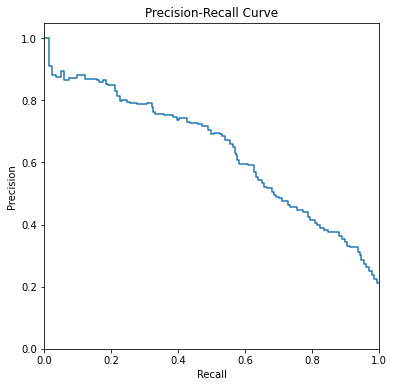

In [58]:
probabilities_probe = best_model.predict_proba(features_probe) 
precision, recall, thresholds = precision_recall_curve(target_probe, probabilities_probe[:, 1] ) 
plt.figure(figsize=(6, 6)) 
plt.step(recall, precision, where='post') 
plt.xlabel('Recall') 
plt.ylabel('Precision') 
plt.ylim([0.0, 1.05]) 
plt.xlim([0.0, 1.0]) 
plt.title('Precision-Recall Curve') 
plt.show() 

Vemos como la curva ahora es más alta que anterioemente

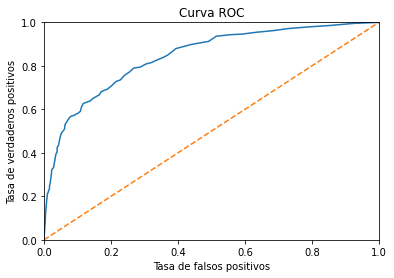

In [59]:
fpr, tpr, thresholds = roc_curve(target_probe, probabilities_one_probe) 
plt.figure()

# < traza la gráfica >
plt.plot(fpr, tpr, linestyle='-')
# Curva ROC para modelo aleatorio (parece una línea recta)
plt.plot([0, 1], [0, 1], linestyle='--')

# < utiliza las funciones plt.xlim() y plt.ylim() para
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
# < utiliza las funciones plt.xlabel() y plt.ylabel() para
#   nombrar los ejes "Tasa de falsos positivos" y "Tasa de verdaderos positivos">
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
# < agrega el encabezado "Curva ROC" con la función plt.title() >
plt.title('Curva ROC')
plt.show()

Y como nuestro modelo no es aleatorio, sino que en verdad predice y mejor que antes

#### Conclisión intermedia

Como podemos ver, podemos conlcuir en este caso al separar los conjuntos de datos, es posible obtener resultados bastente óptimos, que al apliacar conjuntos externos de datos, nos permiten predecir con muy buena precisión y exactitud los resultados que queremos, y que mientras más data se tiene, mejores serán los resultados que podemos obtener, ya que será más sencillo encontrar relaciones entre los datos.

## **CONCLUSIÓN GENERAL**

En conclusión durante el preprocesamiento de los datos se observó la presencia de algunos valores ausnetes en la columna de `Tenure` el cual contiene información sobre el período durante el cual ha madurado el depósito a plazo fijo de un cliente (años) cuya ausencia lo que puede significar que no posee ningún depósito de este típo, por lo cual el espacio se dejó en blanco y para no perder las caracteríasticas simplemenete sustituiremos el valor por 0.

Además no existe un valor demasiado claro que nos permita determinar si un cliente se irá o no, vemos que las variaciones son bastente sutiles, es por eso que se recurre al Machine Learning

Así mismo, se intentó utilizar un m,odelo de regresión logística en el cual no obtuvimos bueno resultados, por lo que se decide cambiar a un modelo de bosque aleatorio de decisión

Luego, podemos conlcuir en este caso con el modelo de arbol aleatorio de decisión al separar los conjuntos de datos, es posible obtener resultados bastente óptimos, que al apliacar conjuntos externos de datos, nos permiten predecir con muy buena precisión y exactitud los resultados que queremos, en este caso obtuvimos los siguientes valores:

* F1 = 60.8 %
* recall = 55.56 %
* precision = 67.14 %
* Auc-Roc = 84.33 %
* Excatitud = 85.1 %

Lo que quiere decir que se tiene un modelo lo suficientemente bueno como para tener una exactitud del 85,1% con buenos niveles de sensibilidad y presición el cual no toma desiciones aleatorias, siendo ápto para predecir si un cliente se va a ir o no del banco y poder tomar las medidas necesarias para que este se mantenga